# Regressão Linear 
# Prevendo resistência do cimento à compressão


É possível prever a resistência de um cimento dados seus ingredientes e sua idade? Se existe uma relação entre essas variáveis, quão forte ela é? Quais variáveis contribuem para a predição?

## Imports

In [1]:
#import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#supress warnings
import warnings
warnings.filterwarnings("ignore")

## Data Exploration

In [2]:
data = pd.read_csv('Concrete_Data_Yeh.csv')
data.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cement            1030 non-null   float64
 1   slag              1030 non-null   float64
 2   flyash            1030 non-null   float64
 3   water             1030 non-null   float64
 4   superplasticizer  1030 non-null   float64
 5   coarseaggregate   1030 non-null   float64
 6   fineaggregate     1030 non-null   float64
 7   age               1030 non-null   int64  
 8   csMPa             1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


**Visualizando como cada atributo está distribuído**

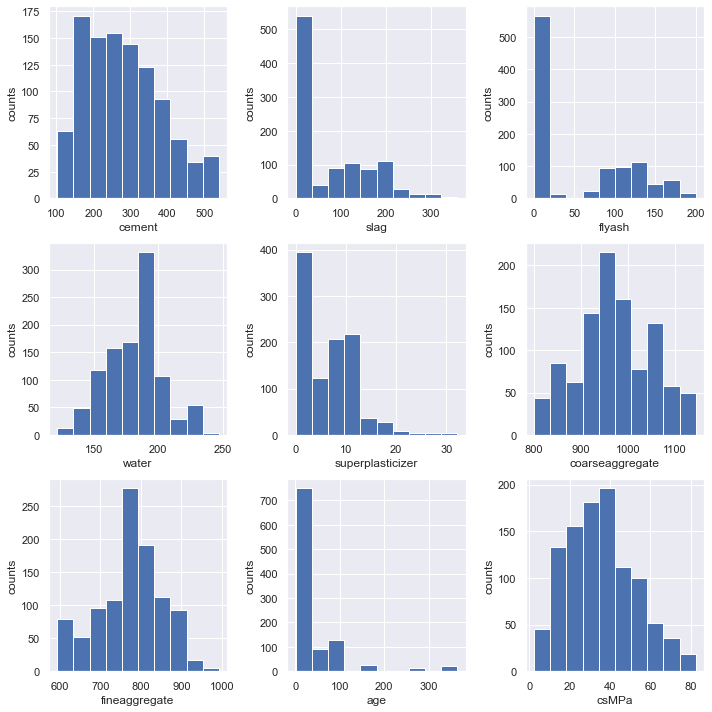

In [4]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.flatten()

for i, col in enumerate(data.columns):
    ax = axs[i]
    ax.hist(data[col])
    ax.set(
    xlabel=col,
    ylabel='counts')

plt.tight_layout()
plt.show()

**Visualizando matriz de correlação dos atributos com o heatmap**

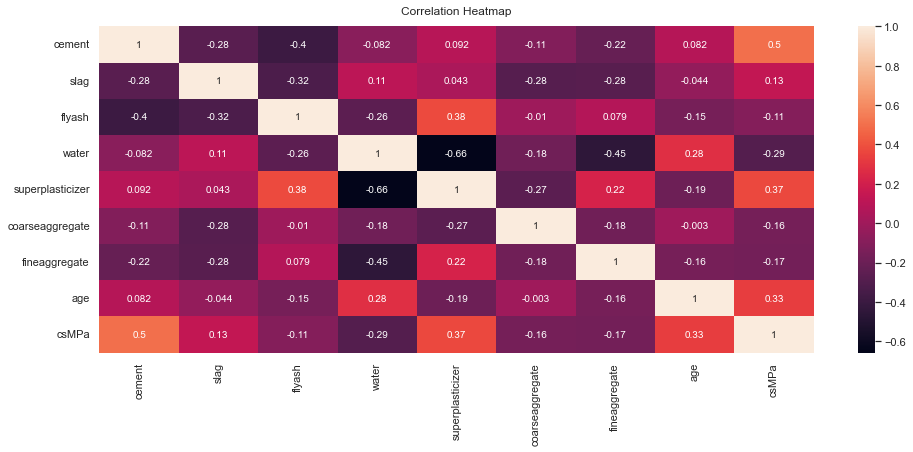

In [5]:
plt.figure(figsize=(16, 6))
sns.heatmap(data.corr(), annot=True)
plt.title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

**Visualizando como a resistência à compressão está distribuída para cada atributo. Para isso, o atributo csMPa é dividido em 4 categorias**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


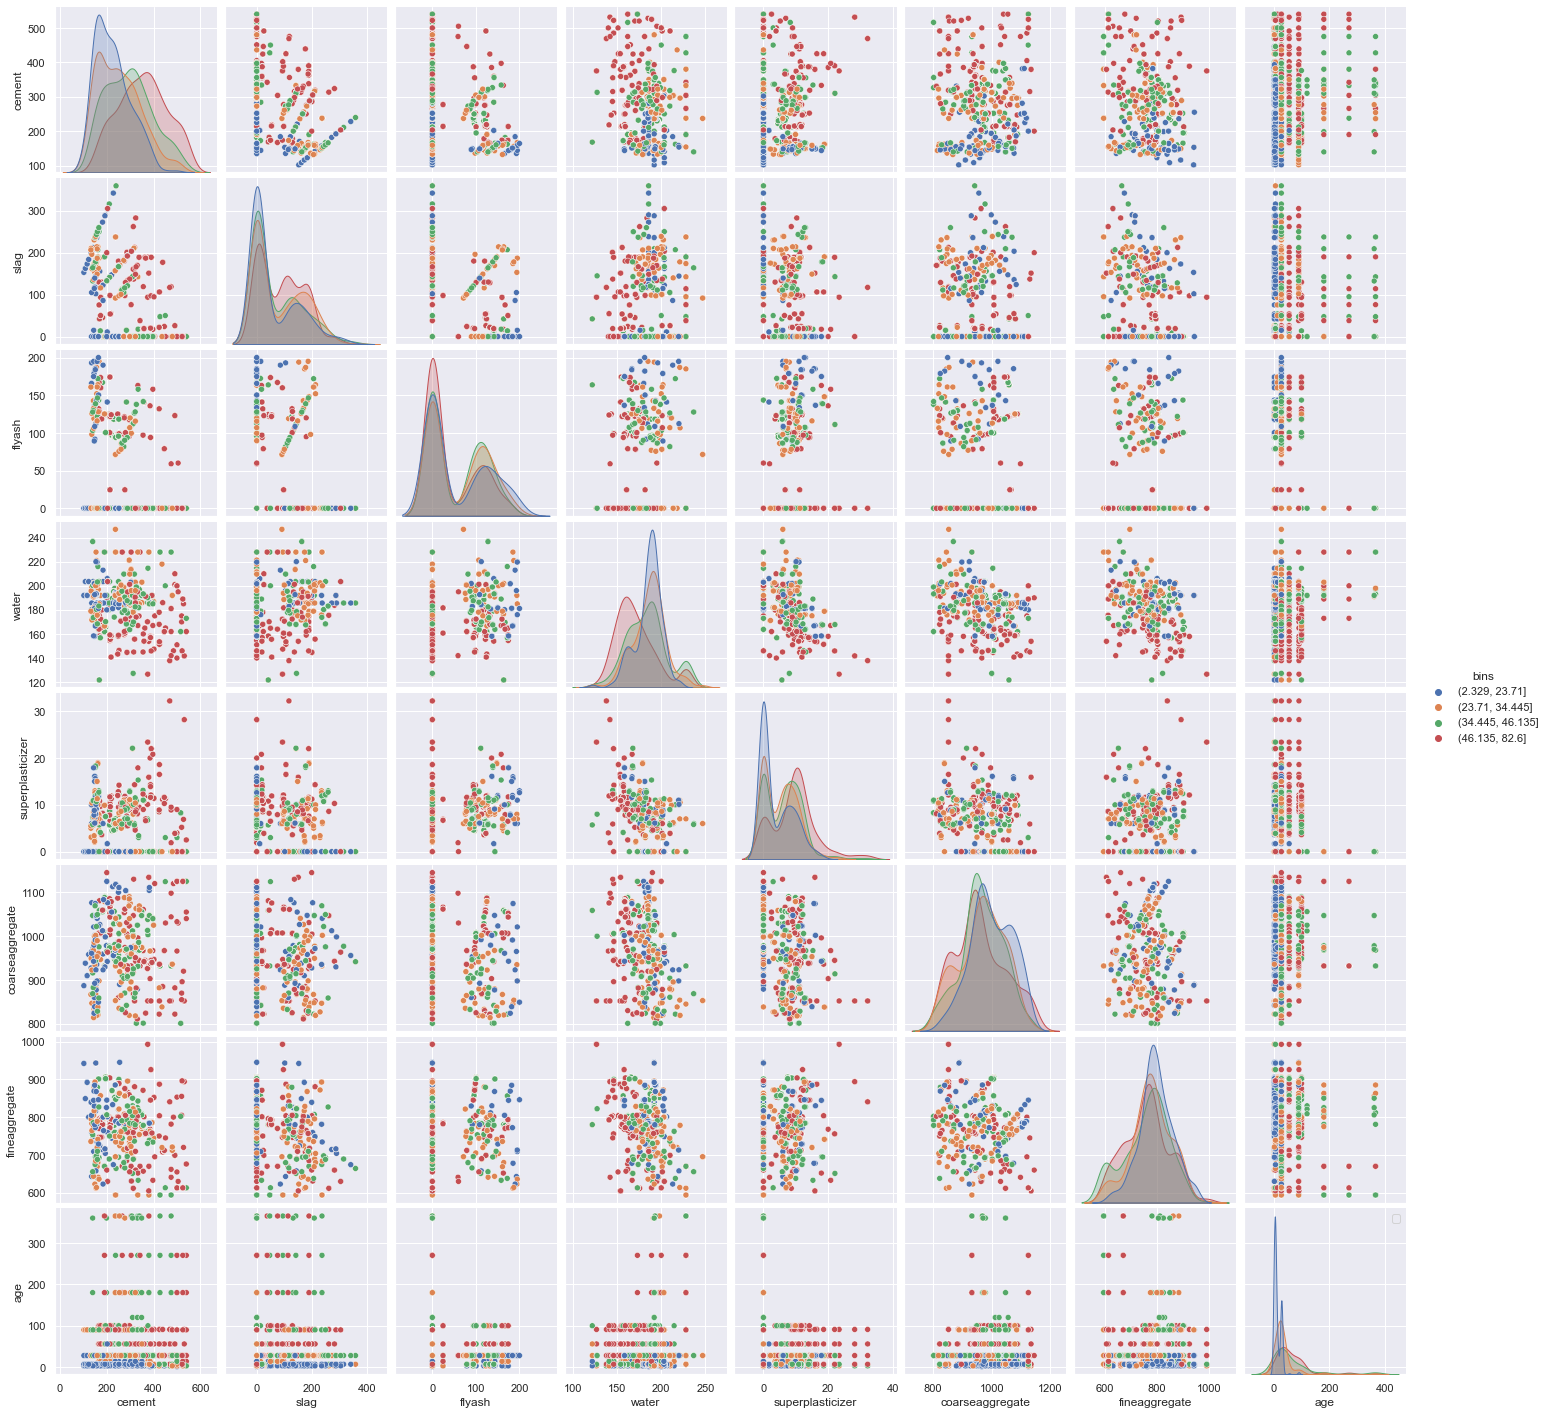

In [6]:
# Criando categorias
bins = pd.qcut(data['csMPa'], q=4)
data['bins']=bins

# Observando dispersão para cada atributo
sns.pairplot(data.loc[:, (data.columns != 'csMPa')], hue='bins')
plt.legend()
plt.show()

data = data.drop('bins', axis=1)

**Criando variável a ser prevista (y) e variáveis preditoras (X)**

In [7]:
X = data.copy()
y = X.pop('csMPa')

## PCA

In [8]:
from sklearn.decomposition import PCA

In [9]:
# Criando cópia de X para fazer o PCA e normalizando
X_PCA = X.copy()
X_PCA = (X_PCA - X_PCA.mean(axis=0)) / X_PCA.std(axis=0)

# Criando PCA
pca = PCA(len(X_PCA.columns))

In [10]:
# Aplicando PCA 
X_pca = pca.fit_transform(X_PCA)
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)
X_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,0.678996,-1.457148,2.386464,-1.351413,0.396508,-0.442745,0.780394,-0.210926
1,0.686313,-1.578675,2.352880,-1.456708,0.390125,-0.382061,0.736633,-0.143536
2,4.153785,0.360166,0.360592,1.474495,1.772937,1.570514,-0.004422,-0.073657
3,4.592136,0.170706,0.511764,2.268422,2.115838,2.689263,0.099897,-0.054285
4,2.362183,-0.275599,-0.276963,2.626302,-0.252528,3.926641,0.419231,0.126254
...,...,...,...,...,...,...,...,...
1025,-0.524533,1.251584,-0.023438,0.458110,0.472877,-0.454481,0.331764,-0.097961
1026,-0.834248,0.746796,0.412457,1.812760,0.553985,-1.417560,-0.177896,-0.018701
1027,-0.184807,1.252531,-1.474559,0.589810,0.208032,-0.386981,0.142131,-0.038523
1028,-0.283562,1.273667,-0.636633,-0.908387,-0.587859,0.935362,-0.754910,-0.182989


In [11]:
loadings = pd.DataFrame(
    pca.components_.T,  
    columns=component_names,  
    index=X_PCA.columns,  
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
cement,0.098401,-0.113737,0.814202,-0.054297,0.148206,-0.203142,0.221844,0.446163
slag,0.177262,0.686053,-0.171794,-0.362699,-0.020932,0.304882,0.228363,0.437384
flyash,-0.394662,-0.142948,-0.408221,0.226751,0.549631,-0.183267,0.352463,0.381886
water,0.547004,0.053256,-0.213190,0.296060,0.070222,-0.365970,-0.524275,0.388741
superplasticizer,-0.505945,0.282930,0.234597,-0.037274,0.354618,0.193294,-0.664643,0.051750
coarseaggregate,0.037928,-0.629943,-0.174088,-0.545805,-0.033083,0.314559,-0.226840,0.349320
fineaggregate,-0.401926,-0.019391,-0.004569,0.385282,-0.701237,0.092466,-0.039026,0.433370
age,0.291479,-0.125981,0.100521,0.527919,0.228010,0.743908,0.069367,0.012881


**É possível observar que 6 componentes já são suficientes para explicar totalmente a variância dos dados**

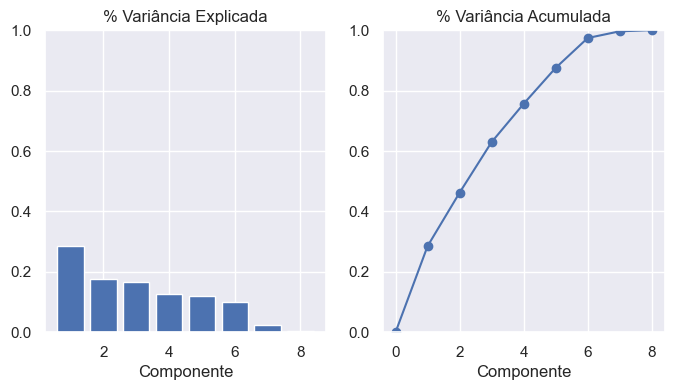

In [12]:
fig, axs = plt.subplots(1, 2)
n = pca.n_components_
grid = np.arange(1, n + 1)

# Variância explicada
evr = pca.explained_variance_ratio_
axs[0].bar(grid, evr)
axs[0].set(
    xlabel="Componente", title="% Variância Explicada", ylim=(0.0, 1.0)
)
# Variância Acumulada
cv = np.cumsum(evr)
axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
axs[1].set(
    xlabel="Componente", title="% Variância Acumulada", ylim=(0.0, 1.0)
)

# Set up figure
fig.set(figwidth=8, dpi=100)
plt.show()

## Regressão MQO (Mínimos quadrados ordinários)

In [13]:
import statsmodels.api as sm

In [14]:
X_sm = sm.add_constant(X)
model = sm.OLS(y,X_sm)
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  csMPa   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     204.3
Date:                Sun, 27 Aug 2023   Prob (F-statistic):          6.29e-206
Time:                        18:45:05   Log-Likelihood:                -3869.0
No. Observations:                1030   AIC:                             7756.
Df Residuals:                    1021   BIC:                             7800.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -23.3312     26.586  

**Observações**

* F-Statistic = 204.3 >> 1 significa que pelo o menos uma das variáveis preditoras está relacionada com a resistência à compressão.
* $R^2 = 0.616$ significa que 61,6% da variância dos dados é explicada pelo modelo
* coarseaggregate e fineaggregate possuem p-valor > 0.05 (portanto, não contribuem para a resistência à compressão nesse modelo)
* Não é possível afirmar que esses atributos não tem influência, devido a possibilidade de multicolinearidade. Para verificar isso, calcula-se o Variance Inflation Factor

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
#initialize VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
#calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

            feature        VIF
0            cement  15.456717
1              slag   3.329127
2            flyash   4.147833
3             water  82.157569
4  superplasticizer   5.471094
5   coarseaggregate  84.955779
6     fineaggregate  72.790995
7               age   1.699459


* Variance Inflation Factor maior que 5 indica multicolinearidade. Portanto, não é possível afirmar que coarseaggregate não é importante 